<a href="https://colab.research.google.com/github/jiminAn/2023_SUMMER_SAMSUNG_DL/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/Day2/Day2_3_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day2.3 Fashion MNIST

### 실습 목표
- 운동화, 셔츠, 샌들 등으로 이루어진 Fashion MNIST 데이터를 사용하여 classificaiton model 학습
  <details>
  - Fashion MNIST: 28*28, 70,000개 데이터로 구성

  ![img.png](https://codetorial.net/tensorflow/_images/fashion_MNIST_sample.png)

  </details>


## 0. Setting
- DL 관련 library 호출
- GPU 설정

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [54]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


## 1. Fashion MNIST 데이터셋 살펴보기


### 1.1 PIL image를 model학습을 위해 tensor형태로 변경
- `transforms.ToTensor()`
  - ToTensor는 매우 일반적으로 사용되는 conversion transform으로, 입력 데이터가 NumPy 배열 또는 PIL 이미지 형식인 경우 ToTensor를 사용하여 텐서 형식으로 변환 가능. (PyTorch에서 주로 텐서 형태의 데이터로 작업)

In [55]:
from torchvision import datasets, transforms, utils

# 데이터를 tensor로 바꿔주기
transform = transforms.ToTensor()

### 1.2 데이터 셋 불러오기
#### Dataset: 샘플과 레이블 저장
- `root` 는 학습/테스트 데이터가 저장되는 경로입니다.

- `train` 은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.

- `download=True` 는 root 에 데이터가 없는 경우 인터넷에서 다운로드합니다.

- `transform`은 특징(feature)과 정답(label) 변형(transform)을 지정합니다.

In [56]:
train_data = datasets.FashionMNIST(
    root      = './data/',
    train     = True,
    download  = True,
    transform = transform
)

test_data = datasets.FashionMNIST(
    root      = './data/',
    train     = False,
    download  = True,
    transform = transform
)

#### DataLoader
: `Dataset`을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싸는 역할


In [57]:
from torch.utils import data

BATCH_SIZE = 64
train_loader = data.DataLoader(
    dataset     = train_data,
    batch_size  = BATCH_SIZE
)
test_loader = data.DataLoader(
    dataset     = test_data,
    batch_size  = BATCH_SIZE
)

### 1.3 데이터 셋 순회 및 시각화

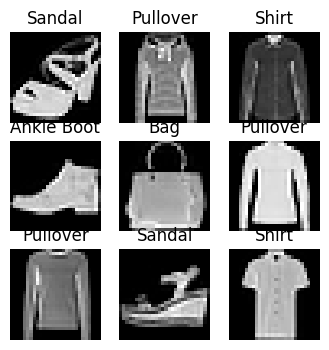

In [58]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. 모델 구성 및 학습

### 2.1 모델 구성
#### nn.Linear(input_dim, output_dim)
- `input_dim`: 입력되는 x의 차원(input sample의 size)
- `output_dim`: 출력되는 y의 차원(output sample의 size)

- 3개의 fully connected layer로 구성
  - linear layer인 fc1을 거치기 위해 flatten 필요
- fc1, fc2는 relu activation function을 포함
  - 입력데이터를 받아 각 레이어마다 w, b를 계산해야 함
  - 따라서 backpropagation에서 발생할 수 있는 vanishing gradient 문제를 해결하기 위해 activation function 적용
- fc3은 최종적으로 10개의 각 클래스에 대한 값을 출력

![image.png](https://blog.kakaocdn.net/dn/b5XcJp/btqWUpKHPTL/wy9Z1Kg41sn6Nbqe2IKBMk/img.png)

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256) # (input:28*28(image size), output: 256)
        self.fc2 = nn.Linear(256, 128) # (input:256, output: 128)
        self.fc3 = nn.Linear(128, 10) # (input:128, output: 10(# of class))

    def forward(self, x):
        x = x.view(-1, 784) # flatten : (1,28,28) -> (1,784)
        x = F.relu(self.fc1(x)) # (1,784) -> fc1 -> (1, 256)
        x = F.relu(self.fc2(x)) # (1,256) -> fc2 -> (1, 128)
        x = self.fc3(x)  # (1,128) -> fc2 -> (1, 128)

        return x

In [60]:
# Model을 GPU에 얹어줌
model = Net().to(DEVICE)

### 2.2 모델 학습

In [61]:
EPOCHS = 20

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.1)

In [62]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [63]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.max(dim=1)[1]
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [64]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.0129, Accuracy: 69.80%
[2] Test Loss: 0.0102, Accuracy: 77.24%
[3] Test Loss: 0.0091, Accuracy: 79.83%
[4] Test Loss: 0.0085, Accuracy: 80.65%
[5] Test Loss: 0.0082, Accuracy: 81.10%
[6] Test Loss: 0.0080, Accuracy: 81.76%
[7] Test Loss: 0.0078, Accuracy: 82.19%
[8] Test Loss: 0.0076, Accuracy: 82.51%
[9] Test Loss: 0.0075, Accuracy: 82.81%
[10] Test Loss: 0.0073, Accuracy: 83.15%
[11] Test Loss: 0.0072, Accuracy: 83.49%
[12] Test Loss: 0.0071, Accuracy: 83.77%
[13] Test Loss: 0.0070, Accuracy: 84.01%
[14] Test Loss: 0.0069, Accuracy: 84.30%
[15] Test Loss: 0.0068, Accuracy: 84.48%
[16] Test Loss: 0.0067, Accuracy: 84.61%
[17] Test Loss: 0.0066, Accuracy: 84.83%
[18] Test Loss: 0.0065, Accuracy: 85.00%
[19] Test Loss: 0.0064, Accuracy: 85.23%
[20] Test Loss: 0.0063, Accuracy: 85.44%


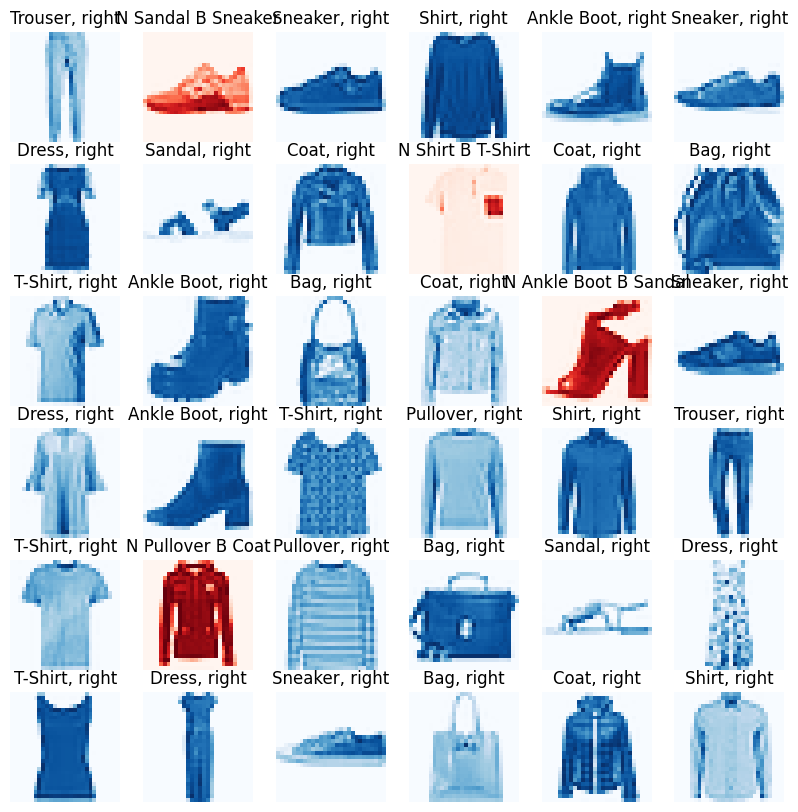

In [65]:
# 결과 시각화
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(DEVICE)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()